# Capstone
## *Show Me the Monet!*
### *Or how I learned to stop worrying, and apply neural networks to artistic recognition.*

The focus of this final project was to gain an understanding of neural networks that was not covered during my time at General Assembly. This required a large amount of learning with respect to neural networks and how they are used in image classification. 

To begin the project needed to decide what set up to use. Settled on Keras on top of theano. Had some experience with Theano from Daniel Nouri's fantastic [facial analysis](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/) work. Additional goals for the project were to determine what key features were identified by the model in classifying Monets versus other works. 

Monet was the artist chosen for this task specifically due to the changes that were present over the course of his work. Cataracts affected him later in life. This caused his paintings to have a less focused appearance. Additionally cataracts cause people to perceive a higher presence of red, which was also observed in his works. 

The stretch objective of this project was also to be able to use the neural network to create photos that have been manipulated to appear like works of Monet. This may require additional work following the end of the course. 

# Initial Image Exploration

To begin, it would be interesting to look at a few monet paintings to see how his early, middle, and late works differ. Through using the [opencv](http://opencv-python-tutroals.readthedocs.io/en/latest/index.html) package RGB histograms for an image of each period were constructed.  
The histograms of an example of each of these periods will be used to show that the color is not the only metric that can be used to identify monet, and that his style is most important in the determination of a Monet. This means that the algorithm needs to work to identify a style consistent with Monet. 

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def rgb_hist(img_path, img_name):
    '''Function to Output Histogram from RGB Image'''
    img = img_path
    rgb = ('r', 'g', 'b')
    for pxl, colors in enumerate(rgb):
        rgb_hist= cv2.calcHist([cv2.imread(img)], [pxl], None, [256], [0,256])  
        plt.plot(rgb_hist, color=colors)                                    
        plt.xlim([0,256])
    plt.title("Color Histogram for " + str(img_name))
    plt.show()

The first image that was passed through this function was Monet's *La Gare Saint-Lazare*, which was painted in 1877. A relatively early painting by him, it shows his dedication to capturing the colors and motion that would come to define the impressionist movement. 
!["La Gare Saint-Lazare"](https://snag.gy/2Nm4XE.jpg)

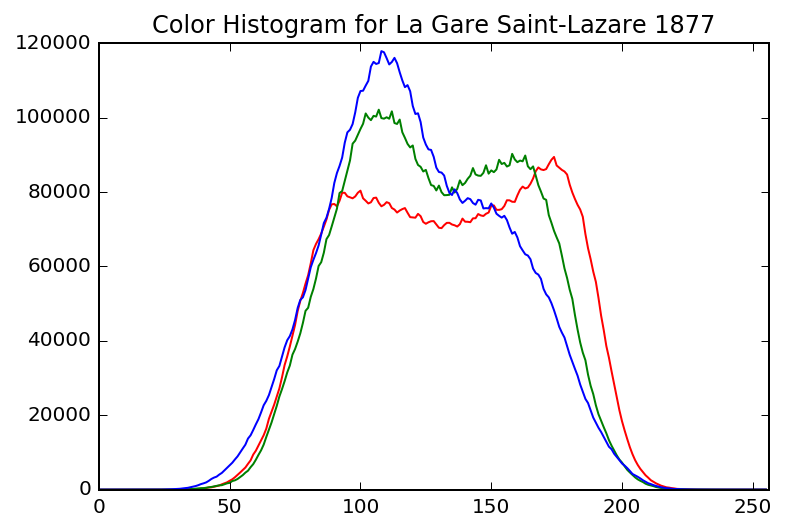

In [5]:
early = 'Photos/Early - La Gare Saint-Lazare 1877.jpg'
name = 'La Gare Saint-Lazare 1877'
rgb_hist(early, name)

Second was one of Monet's Water Lilies. This painting was after his style had been refined and he was experimenting with more patoral scenes. This was still before the appearance of his cataracts. 
!["Water Lilies and Reflections of a Willow"](https://snag.gy/deqnpl.jpg)

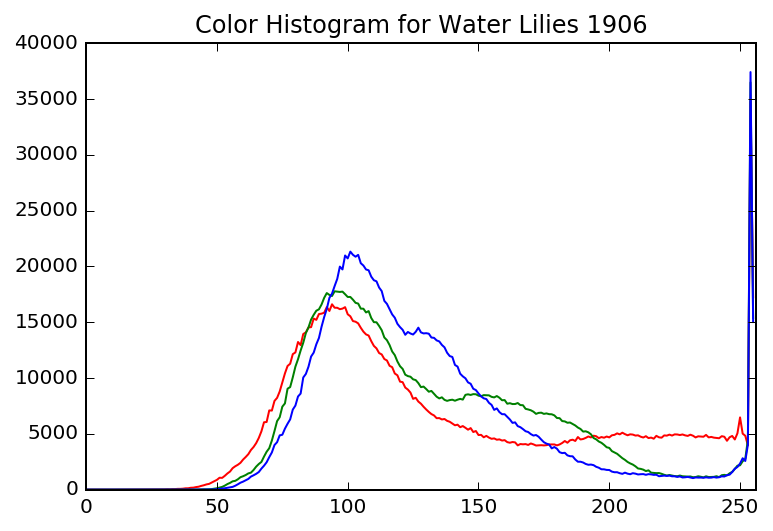

In [6]:
mid = 'Photos/Mid - Water Lilies1906.jpg'
name = 'Water Lilies 1906'
rgb_hist(mid, name)

The final image here is another image of Water Lilies. Monet had cataracts when he painted this interpretation. The colors are certainly much more muted, and red has a much greater weight than the other colors, which is very typical of patients suffering from cataracts. 
!["Water Lilies and Reflections of a Willow"](https://snag.gy/1onP3m.jpg)

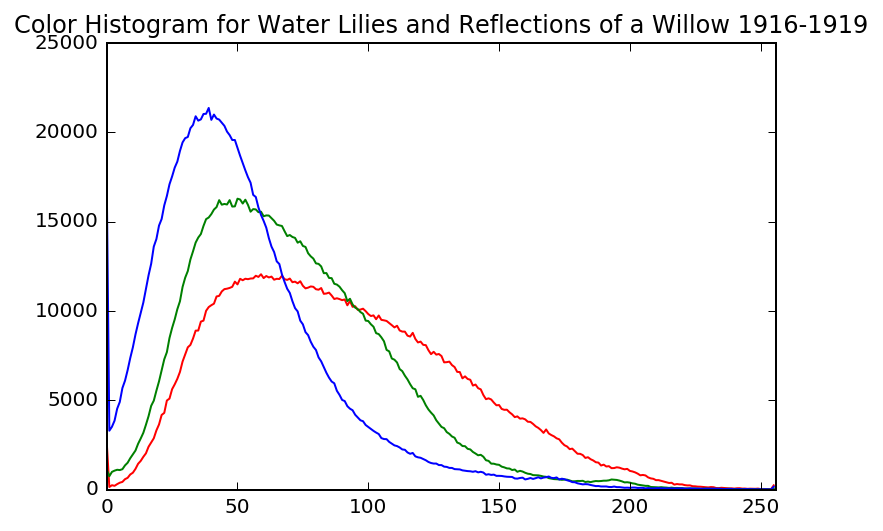

In [7]:
late = 'Photos/Late - Water Lilies and Reflections of a Willow 1916-1919.jpg'
name = 'Water Lilies and Reflections of a Willow 1916-1919'
rgb_hist(late, name)

# Difficulty of Monet

The reason that Monet was the artist chosen for this task was due to the great differences in his style. It would be very interesting to see what paintings that a neural network would be able to classify and where it has struggles. It is expected that there is a distinct style to Monet that would be possible to detect through an algorithm.  
With that in mind, there are certainly paintings for every artist that are a break from their traditional style. That in mind, it would be very interesting to determine 

In [1]:
from keras.models import Sequential        # Linear stack of 'neurons'
import numpy as np


from keras.layers import (                 # Flattened list of layers
    
                          Convolution2D,   # Filters via windows of 2d input
                          MaxPooling2D,    # Subsets image into matrices, largest value of matrix is taken
                          Activation,      # Filters tha activate when deisred features are identified
    
                          Dropout,         # Prevents overfitting by dropping based on probability 1-p
                          Flatten,         # Layers comprising model graph
                          Dense            # Specify input argument shape
    
                          )

Using Theano backend.


Below is a quick demonstration of how the image processing works. A photo that is fed through the below features will have a variety of transformations applied to it. 

In [2]:
# Data Cleaning and Preparation

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array,load_img
from keras.callbacks import History


d_gen = ImageDataGenerator( 
                            rotation_range=0.15,    # Random Roation within specified range
                            width_shift_range=0.15, # Horizontal shift as a fractional of image width
                            height_shift_range=0.15, # Vertical shift as fraction of image height
                            shear_range=0.15, # Intensity of shear
                            zoom_range=0.15, # Either number or list, but specifies the range for the random zoom
                            
            
                            fill_mode='nearest', # How pixels outside of the boundary are dealt with
                            horizontal_flip=True, # Random horizontal flip of sample
                            vertical_flip=True, # Random vertical flip of sample
                            rescale=1./225, # Scalar multiplying the image. 1 used  
#                             dim_ordering=K.image_dim_ordering()
                          )

In [11]:
monet1 = load_img('mod/Claude_Monet,_Impression,_soleil_levant.jpg') # PIL image
monet_array = img_to_array(monet1) # Convert the 2d Image to an array
monet_array = monet_array.reshape((1,) + monet_array.shape) # Reshape to 1D

In [12]:
t = 0
for batch in d_gen.flow(monet_array, batch_size=1,
                        save_to_dir='mod', save_prefix='monet', 
                        save_format='jpeg'):
    t += 1
    if t > 20: # Create 20 manipulated images
        break 

As an example this image

![Soleil Levant](https://snag.gy/EFj8z3.jpg)

Undergoes these following twenty transformations. 

[Modified Monet](https://giphy.com/gifs/goUlPPsMzrGXS)

# Creation of the Model

*Originally the model used was a three step neural network, but it was expanded up to four. This was becasue the initial data used in exploration did not have great fidelity. When the resolution of the input photos was increased, the reliability of the model was suitable for the introduction of another layer in order for more detailed classification.*

In [24]:


model = Sequential()

# Four Layers. Expanded from three due to increased accuracy

model.add(Convolution2D(32,3,3, input_shape=(3,200,200)))
model.add(Activation('relu'))
model.add(Dropout(0.2))  
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Convolution2D(64,2,2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(128,2,2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(256,3,3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))




# Build the model

In [25]:
# model.summary()

In [26]:
model.add(Flatten())

# Have two dropouts in order to reduce overfitting. 

model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))                 
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.5))                 
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [27]:
from keras.utils.visualize_util import plot
import pydot
plot(model, show_shapes=True, to_file='model.png')

The overall structure of the model 

In [28]:
# use the above datagen for training
d_gen = ImageDataGenerator(rescale=1./255,
                          shear_range=0.2,
                          zoom_range=0.2,
                          horizontal_flip=True)

# For test only use a rescale function
test_d_gen = ImageDataGenerator(rescale=1./255)

*The images were organized into two directories. A test directory which would be used to train the neural network, and a validation directory where the model would be tested against. Inside each of those directories were two additional directories a Monet and a Not_Monet. These two directories label the images as they are passed into the neural network. 

In [29]:
import numpy as np

monet_gen = d_gen.flow_from_directory('/Users/sebozek/Desktop/Better_Data/Test/',       # Folder containing the test images
                                     target_size = (200, 200),              # Resize to 150 * 150 pxs
                                     batch_size = 25,                       # Reduce Noise, larger batch less noise
                                     class_mode='binary')                   # Binary Classification Problem

# bottleneck_features_train = model.predict_generator(monet_gen, 1500)
# np.save(open('bottleneck_features_train.npy', 'w'), bottleneck_features_train)

hold_out = d_gen.flow_from_directory('/Users/sebozek/Desktop/Better_Data/Hold_Out/',
                                         target_size= (200, 200),
                                         batch_size = 25,
                                         class_mode='binary')

# bottleneck_features_validation = model.predict_generator(hold_out, 1000)
# np.save(open('bottleneck_features_validation.npy', 'w'), bottleneck_features_validation)

Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


To avoid `Epoch comprised more than 'samples_per_epoch' samples` error need to make sure that batch size is divisible into 

In [37]:
history = model.fit_generator(monet_gen,                  # Resize the image get from test dictionary
                   samples_per_epoch=125,      # How many samples to use per epoch
                   nb_epoch=250,                 # Number of epochs used
                   validation_data = hold_out,  # Location of the validation data
                   nb_val_samples=250,          # Validation samples used per epoch
                   verbose=1,
                   )

model.save_weights('monet_weights.h5', overwrite=True)

Epoch 1/10
125/125 [==============================] - 46s - loss: 0.1513 - acc: 0.9360 - val_loss: 0.4939 - val_acc: 0.8120
Epoch 2/10
125/125 [==============================] - 33s - loss: 0.3452 - acc: 0.8800 - val_loss: 0.4146 - val_acc: 0.8280
Epoch 3/10
125/125 [==============================] - 34s - loss: 0.1698 - acc: 0.9440 - val_loss: 0.3604 - val_acc: 0.8840
Epoch 4/10
125/125 [==============================] - 33s - loss: 0.3847 - acc: 0.8720 - val_loss: 0.4004 - val_acc: 0.8560
Epoch 5/10
125/125 [==============================] - 33s - loss: 0.1351 - acc: 0.9200 - val_loss: 0.3624 - val_acc: 0.8560
Epoch 6/10
125/125 [==============================] - 33s - loss: 0.1621 - acc: 0.9360 - val_loss: 0.4010 - val_acc: 0.8440
Epoch 7/10
125/125 [==============================] - 33s - loss: 0.1329 - acc: 0.9360 - val_loss: 0.3927 - val_acc: 0.8560
Epoch 8/10
125/125 [==============================] - 36s - loss: 0.1076 - acc: 0.9600 - val_loss: 0.4508 - val_acc: 0.8400
Epoch 9/

In [38]:
print(history.history.keys())

['acc', 'loss', 'val_acc', 'val_loss']


## Model Validation

*Comparing the loss and accuracy the network experiences between the test directory and the validation directory was used in order to determine how effective the model was. A gap is to be expected between the two, but the size of that gap can be used to determine effectiveness of the model. Ideally the gap would be minimal.

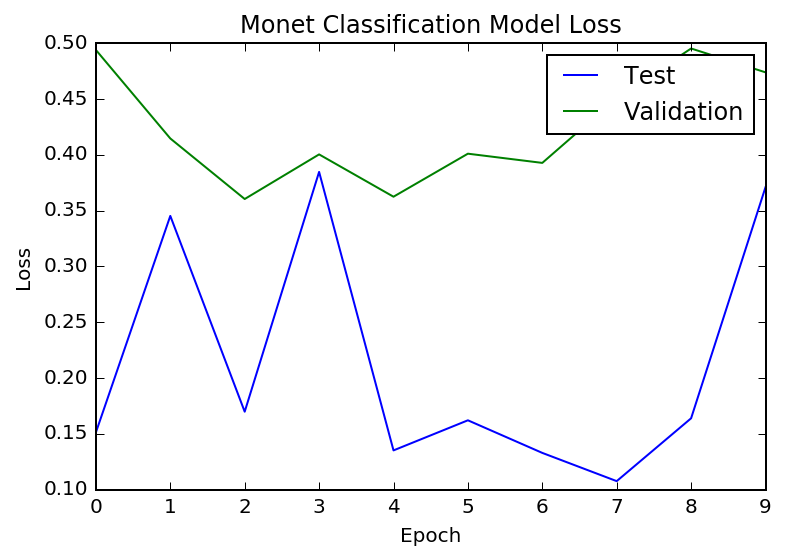

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Monet Classification Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Test', 'Validation'], loc='upper right')

plt.show()

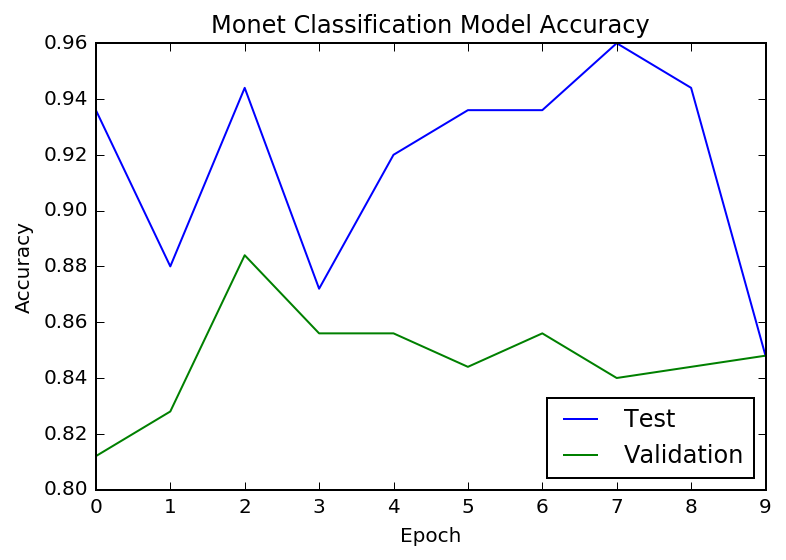

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Monet Classification Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Test', 'Validation'], loc='lower right')

plt.show()

In [51]:
monet_gen = d_gen.flow_from_directory('/home/sambozek/Desktop/Better_Data/Hold_Out',       # Folder containing the test images
                                     target_size = (200, 200),              # Resize to 150 * 150 pxs
                                     batch_size = 25,                       # Reduce Noise, larger batch less noise
                                     class_mode='binary')                   # Binary Classification Problem


Found 500 images belonging to 2 classes.


# Comparing to VGG16

The VGG16 Model is not one of my own creation, but one from the visual group at Oxford University  
* [VGG16](http://www.robots.ox.ac.uk/~vgg/research/very_deep/)   
* [VGG16 in Caffe](https://gist.github.com/ksimonyan/211839e770f7b538e2d8#file-readme-md)  
* [VGG16 in Keras](https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3)

It is a famous convolutional neural network that was used in an image recognition competition, ILSVRC-2014, to great success.It would be interesting to compare a keras instituted version of the famous neural network along with the weights that were found in the competition. The weights file is exceptionally large, due to the complexity of the challenge that was presented. 

In [66]:
from keras.layers import ZeroPadding2D

vgg16 = Sequential()
vgg16.add(ZeroPadding2D((1,1),input_shape=(3,200,200)))
vgg16.add(Convolution2D(64, 3, 3, activation='relu'))
vgg16.add(ZeroPadding2D((1,1)))
vgg16.add(Convolution2D(64, 3, 3, activation='relu'))
vgg16.add(MaxPooling2D((2,2), strides=(2,2)))

vgg16.add(ZeroPadding2D((1,1)))
vgg16.add(Convolution2D(128, 3, 3, activation='relu'))
vgg16.add(ZeroPadding2D((1,1)))
vgg16.add(Convolution2D(128, 3, 3, activation='relu'))
vgg16.add(MaxPooling2D((2,2), strides=(2,2)))

vgg16.add(ZeroPadding2D((1,1)))
vgg16.add(Convolution2D(256, 3, 3, activation='relu'))
vgg16.add(ZeroPadding2D((1,1)))
vgg16.add(Convolution2D(256, 3, 3, activation='relu'))
vgg16.add(ZeroPadding2D((1,1)))
vgg16.add(Convolution2D(256, 3, 3, activation='relu'))
vgg16.add(MaxPooling2D((2,2), strides=(2,2)))

vgg16.add(ZeroPadding2D((1,1)))
vgg16.add(Convolution2D(512, 3, 3, activation='relu'))
vgg16.add(ZeroPadding2D((1,1)))
vgg16.add(Convolution2D(512, 3, 3, activation='relu'))
vgg16.add(ZeroPadding2D((1,1)))
vgg16.add(Convolution2D(512, 3, 3, activation='relu'))
vgg16.add(MaxPooling2D((2,2), strides=(2,2)))

vgg16.add(ZeroPadding2D((1,1)))
vgg16.add(Convolution2D(512, 3, 3, activation='relu'))
vgg16.add(ZeroPadding2D((1,1)))
vgg16.add(Convolution2D(512, 3, 3, activation='relu'))
vgg16.add(ZeroPadding2D((1,1)))
vgg16.add(Convolution2D(512, 3, 3, activation='relu'))
vgg16.add(MaxPooling2D((2,2), strides=(2,2)))

vgg16.add(Flatten())
vgg16.add(Dense(4096, activation='relu'))
vgg16.add(Dropout(0.5))
vgg16.add(Dense(4096, activation='relu'))
vgg16.add(Dropout(0.5))
vgg16.add(Dense(1000, activation='softmax'))
vgg16.add(Dense(1, activation='relu'))

In [67]:
vgg16.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [69]:
vgghist = vgg16.fit_generator(monet_gen,                  
                   samples_per_epoch=125,     
                   nb_epoch=250,               
                   validation_data = hold_out, 
                   nb_val_samples=250,         
                   verbose=1,
                )


vgg16.save_weights('monet_vgg16_weights.h5', overwrite=True)

Epoch 1/10
125/125 [==============================] - 238s - loss: 8.2525 - acc: 0.4880 - val_loss: 7.9301 - val_acc: 0.5080
Epoch 2/10
125/125 [==============================] - 226s - loss: 7.2209 - acc: 0.5520 - val_loss: 8.5104 - val_acc: 0.4720
Epoch 3/10
125/125 [==============================] - 1205s - loss: 9.0261 - acc: 0.4400 - val_loss: 7.4143 - val_acc: 0.5400
Epoch 4/10
125/125 [==============================] - 264s - loss: 7.7367 - acc: 0.5200 - val_loss: 8.3814 - val_acc: 0.4800
Epoch 5/10
125/125 [==============================] - 268s - loss: 8.2525 - acc: 0.4880 - val_loss: 8.1880 - val_acc: 0.4920
Epoch 6/10
125/125 [==============================] - 245s - loss: 7.2209 - acc: 0.5520 - val_loss: 7.6722 - val_acc: 0.5240
Epoch 7/10
125/125 [==============================] - 254s - loss: 9.0261 - acc: 0.4400 - val_loss: 8.2525 - val_acc: 0.4880
Epoch 8/10
125/125 [==============================] - 264s - loss: 7.7367 - acc: 0.5200 - val_loss: 7.7367 - val_acc: 0.5200

In [70]:

plot(vgg16, show_shapes=True, to_file='model.png')

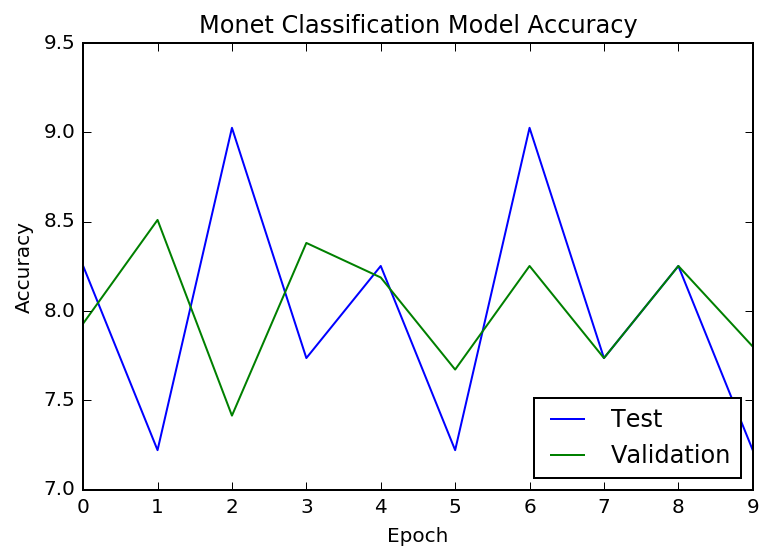

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(vgghist.history['loss'])
plt.plot(vgghist.history['val_loss'])
plt.title('Monet Classification Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Test', 'Validation'], loc='lower right')

plt.show()